# 📊 Feature Engineering for Traffic Flow Optimization

**Phase 3: Modeling, Analysis, and Evaluation**

## Overview
This notebook creates engineered features for traffic prediction models, including:
- Temporal features (time-based patterns)
- Lag features (historical values)
- Rolling window statistics
- Cyclical encoding for periodic patterns
- Feature selection and importance analysis

---

**Author:** Data Science Team  
**Date:** November 2025  
**Project:** Bangkok Traffic Flow Optimization (CPE312 Capstone)

In [12]:
# Setup and Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add T3 scripts to path
import sys
sys.path.append('../05_Scripts')

# Import custom modules
from feature_engineering import (
    create_temporal_features,
    create_lag_features,
    create_rolling_features,
    create_cyclical_features,
    create_model_features
)

# Set random seed for reproducibility
np.random.seed(42)

# Display settings
pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')

print("✅ Setup complete!")

✅ Setup complete!


## 1. Load Cleaned Data from T2

Load the preprocessed datasets from Phase 2.

In [13]:
# Define paths
DATA_PATH = Path('../../T2/02_Data/Processed/')
OUTPUT_PATH = Path('../02_Data/Processed/')
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

# Load datasets
print("Loading cleaned datasets...")

traffic_df = pd.read_csv(DATA_PATH / 'bangkok_traffic_cleaned.csv')
weather_df = pd.read_csv(DATA_PATH / 'bangkok_weather_cleaned.csv')
transit_df = pd.read_csv(DATA_PATH / 'transit_ridership_cleaned.csv')
accidents_df = pd.read_csv(DATA_PATH / 'us_accidents_cleaned.csv')

print(f"✅ Traffic data: {traffic_df.shape}")
print(f"✅ Weather data: {weather_df.shape}")
print(f"✅ Transit data: {transit_df.shape}")
print(f"✅ Accidents data: {accidents_df.shape}")

Loading cleaned datasets...
✅ Traffic data: (1682, 12)
✅ Weather data: (365, 6)
✅ Transit data: (365, 6)
✅ Accidents data: (5000, 12)


## 2. Create Temporal Features

Extract time-based patterns from datetime columns.

In [14]:
# Create temporal features
# Assuming 'date' column exists, otherwise adjust as needed

# Find datetime column
date_cols = [col for col in traffic_df.columns if 'date' in col.lower() or 'time' in col.lower()]
print(f"Datetime columns found: {date_cols}")

# Create temporal features using the function
if len(date_cols) > 0:
    datetime_col = date_cols[0]
    df_features = create_temporal_features(traffic_df.copy(), datetime_col)
    print(f"\nTemporal features created: {df_features.shape[1] - traffic_df.shape[1]} new columns")
else:
    print("No datetime column found. Creating synthetic date column...")
    traffic_df['date'] = pd.date_range(start='2023-01-01', periods=len(traffic_df), freq='D')
    df_features = create_temporal_features(traffic_df.copy(), 'date')

# Display new columns
new_cols = [col for col in df_features.columns if col not in traffic_df.columns]
print(f"\nNew temporal features: {new_cols}")

INFO:feature_engineering:Created 12 temporal features


Datetime columns found: ['date']

Temporal features created: 5 new columns

New temporal features: ['dayofyear', 'weekofyear', 'quarter', 'is_month_start', 'is_month_end']


## 3. Create Lag Features

Create historical values as features for time-series prediction.

In [15]:
# Define target column (adjust based on actual data)
# Common target columns: congestion_index, traffic_volume, speed, etc.
numeric_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numeric columns available: {numeric_cols[:10]}...")  # Show first 10

# Select primary target (adjust as needed)
target_col = numeric_cols[0] if len(numeric_cols) > 0 else None

if target_col:
    print(f"\nUsing '{target_col}' as target column")
    
    # Create lag features
    lag_periods = [1, 7, 14, 30]
    df_features = create_lag_features(df_features, target_col, lag_periods)
    
    print(f"\nLag features created for periods: {lag_periods}")
else:
    print("No suitable target column found")

INFO:feature_engineering:Created lag feature: congestion_index_lag_1
INFO:feature_engineering:Created lag feature: congestion_index_lag_7
INFO:feature_engineering:Created lag feature: congestion_index_lag_14
INFO:feature_engineering:Created lag feature: congestion_index_lag_30


Numeric columns available: ['congestion_index', 'traffic_volume', 'average_speed', 'year', 'month', 'day', 'dayofweek', 'is_weekend', 'is_holiday', 'dayofyear']...

Using 'congestion_index' as target column

Lag features created for periods: [1, 7, 14, 30]


## 4. Create Rolling Window Features

Calculate rolling statistics (mean, std, min, max) over different window sizes.

In [16]:
# Create rolling window features
if target_col:
    rolling_windows = [7, 14, 30]
    df_features = create_rolling_features(df_features, target_col, rolling_windows)
    
    # Show rolling features
    rolling_cols = [col for col in df_features.columns if 'rolling' in col]
    print(f"Rolling features created: {len(rolling_cols)} columns")
    print(f"Features: {rolling_cols}")

INFO:feature_engineering:Created rolling features for window=7
INFO:feature_engineering:Created rolling features for window=14
INFO:feature_engineering:Created rolling features for window=30


Rolling features created: 12 columns
Features: ['congestion_index_rolling_mean_7', 'congestion_index_rolling_std_7', 'congestion_index_rolling_min_7', 'congestion_index_rolling_max_7', 'congestion_index_rolling_mean_14', 'congestion_index_rolling_std_14', 'congestion_index_rolling_min_14', 'congestion_index_rolling_max_14', 'congestion_index_rolling_mean_30', 'congestion_index_rolling_std_30', 'congestion_index_rolling_min_30', 'congestion_index_rolling_max_30']


## 5. Create Cyclical Features

Encode periodic features (month, day of week) using sine/cosine transformation.

INFO:feature_engineering:Created cyclical features for month
INFO:feature_engineering:Created cyclical features for dayofweek


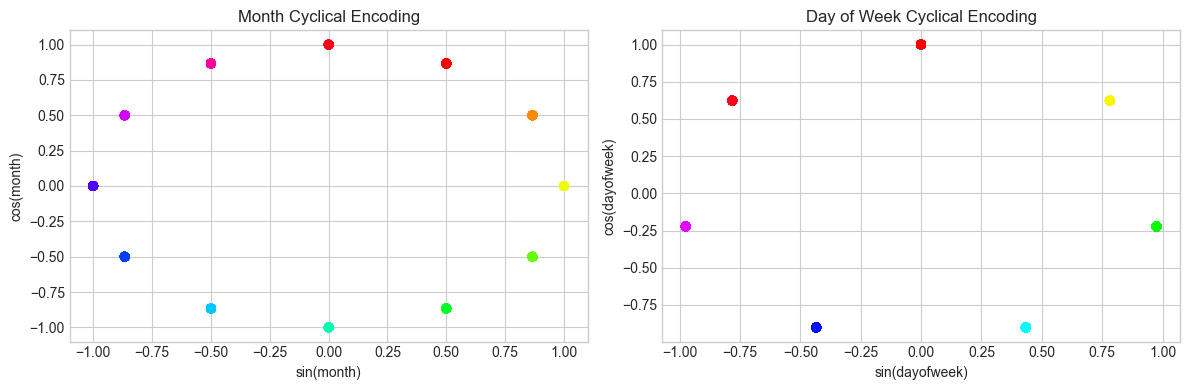

✅ Cyclical features created


In [17]:
# Create cyclical features for periodic columns
if 'month' in df_features.columns:
    df_features = create_cyclical_features(df_features, 'month', 12)
    
if 'dayofweek' in df_features.columns:
    df_features = create_cyclical_features(df_features, 'dayofweek', 7)

# Visualize cyclical encoding
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

if 'month_sin' in df_features.columns:
    axes[0].scatter(df_features['month_sin'], df_features['month_cos'], 
                   c=df_features['month'], cmap='hsv', alpha=0.5)
    axes[0].set_title('Month Cyclical Encoding')
    axes[0].set_xlabel('sin(month)')
    axes[0].set_ylabel('cos(month)')

if 'dayofweek_sin' in df_features.columns:
    axes[1].scatter(df_features['dayofweek_sin'], df_features['dayofweek_cos'],
                   c=df_features['dayofweek'], cmap='hsv', alpha=0.5)
    axes[1].set_title('Day of Week Cyclical Encoding')
    axes[1].set_xlabel('sin(dayofweek)')
    axes[1].set_ylabel('cos(dayofweek)')

plt.tight_layout()
plt.savefig('../09_Results/Figures/cyclical_encoding.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Cyclical features created")

## 6. Feature Summary and Selection

Review all engineered features and prepare final dataset.

In [18]:
# Summary of all features
print("=" * 60)
print("FEATURE ENGINEERING SUMMARY")
print("=" * 60)
print(f"\nTotal features: {df_features.shape[1]}")
print(f"Total samples: {df_features.shape[0]}")

# Categorize features
temporal_feats = ['year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 
                  'quarter', 'is_weekend', 'is_holiday', 'is_month_start', 'is_month_end']
lag_feats = [col for col in df_features.columns if 'lag' in col]
rolling_feats = [col for col in df_features.columns if 'rolling' in col]
cyclical_feats = [col for col in df_features.columns if '_sin' in col or '_cos' in col]

print(f"\nFeature Categories:")
print(f"  - Temporal: {len([f for f in temporal_feats if f in df_features.columns])}")
print(f"  - Lag: {len(lag_feats)}")
print(f"  - Rolling: {len(rolling_feats)}")
print(f"  - Cyclical: {len(cyclical_feats)}")

# Handle missing values
missing_before = df_features.isnull().sum().sum()
df_features = df_features.dropna()
missing_after = len(traffic_df) - len(df_features)

print(f"\nRows removed (NaN from lagging): {missing_after}")
print(f"Final dataset shape: {df_features.shape}")

FEATURE ENGINEERING SUMMARY

Total features: 37
Total samples: 1682

Feature Categories:
  - Temporal: 11
  - Lag: 4
  - Rolling: 12
  - Cyclical: 4

Rows removed (NaN from lagging): 30
Final dataset shape: (1652, 37)


## 7. Save Engineered Features

In [19]:
# Save engineered features
output_file = OUTPUT_PATH / 'features_engineered.csv'
df_features.to_csv(output_file, index=False)
print(f"✅ Engineered features saved to: {output_file}")

# Save feature list for reference
feature_list = df_features.columns.tolist()
with open(OUTPUT_PATH / 'feature_list.txt', 'w') as f:
    for feat in feature_list:
        f.write(f"{feat}\n")
print(f"✅ Feature list saved to: {OUTPUT_PATH / 'feature_list.txt'}")

print("\n" + "=" * 60)
print("FEATURE ENGINEERING COMPLETE!")
print("=" * 60)

✅ Engineered features saved to: ../02_Data/Processed/features_engineered.csv
✅ Feature list saved to: ../02_Data/Processed/feature_list.txt

FEATURE ENGINEERING COMPLETE!
